In [1]:
import numpy as np
import scipy.constants
import os
import random
from view_control import adjust_origin
from simulation import process_spectrogram

dataset_folder = '/home/yi/Desktop/momask-codes/signal_processing/generation'
output_folder = '/home/yi/Desktop/momask-codes/signal_processing/spec'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
for subdir in os.listdir(dataset_folder):
    subdir_path = os.path.join(dataset_folder, subdir)
    if os.path.isdir(subdir_path):
        # Create train and test subdirectories
        train_subdir = os.path.join(output_folder, 'train', subdir)
        test_subdir = os.path.join(output_folder, 'test', subdir)
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)
        if not os.path.exists(test_subdir):
            os.makedirs(test_subdir)
            
        skel_files = [file for file in os.listdir(subdir_path) if file.endswith('.npy')]
        random.shuffle(skel_files)  # Shuffle the list for randomness
        
        # Split files into 80% train and 20% test
        split_index = int(0.8 * len(skel_files))
        train_files = skel_files[:split_index]
        test_files = skel_files[split_index:]
        
         # Process and save files for train set
        for file_index, file in enumerate(train_files):
            file_path = os.path.join(subdir_path, file)
            skel_hist = np.load(file_path)
            output_file = os.path.join(train_subdir, f'{file_index}.npy') 
            # Define the original origin
            origin = (0, -3, 0.5)
            # Generate a random delta angle between -15 and 15 degrees
            delta_angle = random.uniform(-15, 15)
            new_origin = adjust_origin(skel_hist, origin, delta_angle)
            sx2, timeAxis, freqAxis  = process_spectrogram(skel_hist, new_origin, rcs_flag = True)
            result= {'spec': sx2, 'time_axis': timeAxis, 'freq_axis': freqAxis}
            np.save(output_file, result)
            break
        break


        # Process and save files for test set
        for file_index, file in enumerate(test_files):
            file_path = os.path.join(subdir_path, file)
            skel_hist = np.load(file_path)
            output_file = os.path.join(test_subdir, f'{file_index}.npy') 
            # Define the radar origin
            origin = (0, -3, 0.5)
            sx2, timeAxis, freqAxis  = process_spectrogram(skel_hist, origin, rcs_flag = False)
            result= {'spec': sx2, 'time_axis': timeAxis, 'freq_axis': freqAxis}
            np.save(output_file, result)

#skel_hist = np.load('sample_3.npy')

In [2]:
result = np.load('/home/yi/Desktop/momask-codes/signal_processing/spec/train/quick_sitting/0.npy', allow_pickle=True)

In [3]:
sx2 = result.item().get('spec')
timeAxis = result.item().get('time_axis')
freqAxis = result.item().get('freq_axis')

In [28]:
import numpy as np
import scipy.constants
import os
import random
from view_control import adjust_origin
from simulation import process_spectrogram

dataset_folder = '/home/yi/Desktop/momask-codes/signal_processing/spec_wo_rcs'
output_folder = '/home/yi/Desktop/momask-codes/signal_processing/fig'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
train_spec_data = os.path.join(dataset_folder, 'train')
test_spec_data = os.path.join(dataset_folder, 'test')    

for subdir in os.listdir(test_spec_data):
    subdir_spec_path = os.path.join(test_spec_data, subdir)
    if os.path.isdir(subdir_spec_path):
        # Create train and test subdirectories
        test_fig_subdir = os.path.join(output_folder, 'test', subdir)
        if not os.path.exists(test_fig_subdir):
            os.makedirs(test_fig_subdir)
            
        spec_files = [file for file in os.listdir(subdir_spec_path) if file.endswith('.npy')]
       
        for file_index, file in enumerate(spec_files):
            file_path = os.path.join(subdir_spec_path, file)
            result = np.load(file_path, allow_pickle=True)
            sx2 = result.item().get('spec')
            timeAxis = result.item().get('time_axis')
            freqAxis = result.item().get('freq_axis')       
            break
    break

In [29]:
file_path

'/home/yi/Desktop/momask-codes/signal_processing/spec_wo_rcs/test/quick_sitting/11.npy'

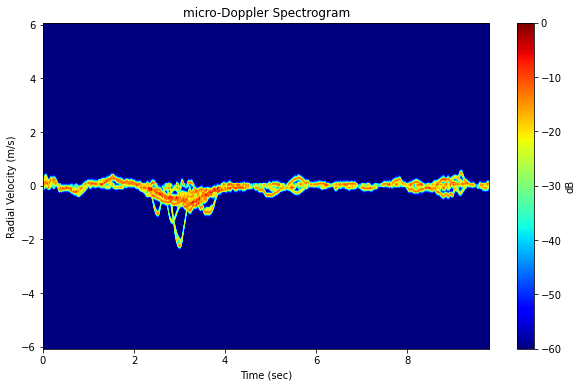

In [47]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(10, 6))
plt.imshow(20 * np.log10(np.abs(sx2 / np.max(sx2))), extent=[timeAxis[0], timeAxis[-1], freqAxis[0], freqAxis[-1]], aspect='auto', origin='lower')
plt.title('micro-Doppler Spectrogram')
plt.xlabel('Time (sec)')
plt.ylabel('Radial Velocity (m/s)')
plt.colorbar(label='dB')
plt.clim(20 * np.log10(np.abs(sx2 / np.max(sx2))).max() - 60, 20 * np.log10(np.abs(sx2 / np.max(sx2))).max())
plt.set_cmap('jet')
#plt.axis([0, 8, -2, 2])
plt.show()

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

def save_spectrogram_image(sx2, spec_length = 1600, dynamic_range = 60, image_path='spectrogram.png'):
    """
    Crop or pad the sx2 data to a fixed length of spec_length and save the data as an image.
    The image size is fixed at [224, 224].
    """
    # Crop or pad sx2 data to a fixed size 
    current_size = sx2.shape[1]
    if current_size < spec_length:
        # Pad
        pad_width = (spec_length - current_size) // 2
        sx2_padded = np.pad(sx2, ((0, 0), (pad_width, spec_length - current_size - pad_width)), 'constant')
    elif current_size > spec_length:
        # Crop
        start_index = (current_size - spec_length) // 2
        sx2_padded = sx2[:, start_index:start_index + spec_length]
    else:
        sx2_padded = sx2

    spec_max = np.log10(np.abs(sx2_padded / np.max(sx2_padded))).max()
    # Visualization and saving
    plt.figure()  
    plt.imshow(20 * np.log10(np.abs(sx2_padded / np.max(sx2_padded))), aspect='auto', origin='lower')
    plt.clim(spec_max - dynamic_range, spec_max)
    plt.set_cmap('jet')
    plt.axis('off')  # No axes for an image
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove padding around the image
    # Save the image
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the plot to free memory

# Example usage:
# save_spectrogram_image(sx2, numCPI, frameDuration, Vmax, nfft, 'spectrogram_image.png')

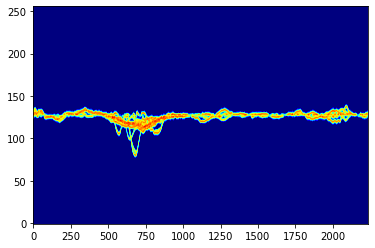

In [71]:
plt.imshow(20 * np.log10(np.abs(sx2 / np.max(sx2))), aspect='auto', origin='lower')
plt.clim(20 * np.log10(np.abs(sx2 / np.max(sx2))).max() - 60, 20 * np.log10(np.abs(sx2 / np.max(sx2))).max())


In [86]:
save_spectrogram_image(sx2, spec_length = 1600, dynamic_range = 60, image_path='spectrogram.png')

/home/yi/Desktop/momask-codes/signal_processing/spec_wo_rcs/train/quick_sitting/39.npy /home/yi/Desktop/momask-codes/signal_processing/fig/train/quick_sitting/39.png


ValueError: Format 'npy' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

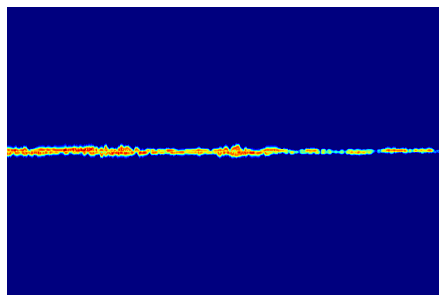

In [94]:
import numpy as np
import os
from visualization import save_spectrogram_image

dataset_folder = '/home/yi/Desktop/momask-codes/signal_processing/spec_wo_rcs'
output_folder = '/home/yi/Desktop/momask-codes/signal_processing/fig'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
train_spec_data = os.path.join(dataset_folder, 'train')
test_spec_data = os.path.join(dataset_folder, 'test')    

for subdir in os.listdir(train_spec_data):
    subdir_spec_path = os.path.join(train_spec_data, subdir)
    if os.path.isdir(subdir_spec_path):
        # Create train and test subdirectories
        train_fig_subdir = os.path.join(output_folder, 'train', subdir)
        if not os.path.exists(train_fig_subdir):
            os.makedirs(train_fig_subdir)

            
        spec_files = [file for file in os.listdir(subdir_spec_path) if file.endswith('.npy')]
       
        for file_index, file in enumerate(spec_files):
            file_path = os.path.join(subdir_spec_path, file)
            save_path = os.path.join(train_fig_subdir, file[:-4]+'.png')
            print(file_path, save_path)
            result = np.load(file_path, allow_pickle=True)
            sx2 = result.item().get('spec')
            save_spectrogram_image(sx2, spec_length = 1600, dynamic_range = 60, image_path=file_path)

            
            
for subdir in os.listdir(test_spec_data):
    subdir_spec_path = os.path.join(test_spec_data, subdir)
    if os.path.isdir(subdir_spec_path):
        # Create train and test subdirectories
        test_fig_subdir = os.path.join(output_folder, 'test', subdir)
        if not os.path.exists(test_fig_subdir):
            os.makedirs(test_fig_subdir)
            
        spec_files = [file for file in os.listdir(subdir_spec_path) if file.endswith('.npy')]
       
        for file_index, file in enumerate(spec_files):
            file_path = os.path.join(subdir_spec_path, file)
            print(file_path)
            result = np.load(file_path, allow_pickle=True)
            sx2 = result.item().get('spec')
            save_spectrogram_image(sx2, spec_length = 1600, dynamic_range = 60, image_path=file_path)

In [84]:
from visualization import save_spectrogram_image
save_spectrogram_image(sx2, spec_length = 1600, dynamic_range = 60, image_path='spectrogram.png')

In [5]:
from view_control import adjust_origin

In [6]:
import random

# Define the original origin
origin = (0, -3, 0.5)

# Generate a random delta angle between -15 and 15 degrees
delta_angle = random.uniform(-15, 15)
print(delta_angle)
# Call the function
new_origin = adjust_origin(skel_hist, origin, delta_angle)
print("Delta Angle:", delta_angle)
print("New Origin:", new_origin)

-13.096031734503452
Delta Angle: -13.096031734503452
New Origin: (-0.6879406402089124, -2.921241576852707, 0.5)


In [7]:
%%time
sx2, timeAxis, freqAxis  = process_spectrogram(skel_hist, new_origin)

CPU times: user 2min 34s, sys: 4.39 s, total: 2min 38s
Wall time: 2min 38s


In [11]:
import json
import numpy as np
from scipy.spatial.distance import cdist
from scipy.interpolate import CubicSpline
from scipy.signal import butter, lfilter


def load_config(filename):
    """
    Loads configuration from a JSON file.
    """
    with open(filename, 'r') as file:
        return json.load(file)
        
        
class RadarRCSProcessor:
    def __init__(self, tar_loc, tx_loc, rx_loc, powerTx, numChirps):
        self.tar_loc = tar_loc
        self.tx_loc = tx_loc
        self.rx_loc = rx_loc
        self.powerTx = powerTx
        self.numChirps = numChirps
        self.amp_all = np.zeros([tar_loc.shape[0],numChirps])

    def rcs_ellipsoid(self, a, b, c, phi, theta):
        """
        Calculate the radar cross section (RCS) of an ellipsoid.
        """
        nomi = np.pi * a**2 * b**2 * c**2
        denomi = ((a**2) * (np.sin(theta)**2) * (np.cos(phi)**2) +
                  (b**2) * (np.sin(theta)**2) * (np.sin(phi)**2) +
                  (c**2) * (np.cos(theta)**2))**2
        return nomi / denomi

    def calculate_angles(self, tx_loc, body_part, aspect_vector, r_dist):
        """
        Calculate theta and phi angles for radar processing.
        """
        A = tx_loc - body_part
        A_dot_aspect_vector = np.dot(A, aspect_vector)
        norm_A = np.sqrt(np.sum(A**2))
        norm_aspect_vector = np.sqrt(np.sum(aspect_vector**2))
        theta_angle = np.arccos(A_dot_aspect_vector / (norm_A * norm_aspect_vector))
        phi_angle = np.arcsin((tx_loc[1] - body_part[1]) / np.sqrt(r_dist[0]**2 + r_dist[1]**2))
        return theta_angle, phi_angle

    def process_body_part(self, target_id, end_part_index, ellipsoid_params):
        """
        Process radar returns for a specific body part.
        """
        body_part = np.zeros([3, self.numChirps])
        ref_point = np.zeros([3, self.numChirps])
        #amp = np.zeros([len(target_id), self.numChirps])

        for k in range(self.numChirps):
            body_part[:, k] = self.tar_loc[end_part_index[0], :, k]
            ref_point[:, k] = self.tar_loc[end_part_index[1], :, k]
            body_part_length = np.sqrt(np.sum((body_part[:, k] - ref_point[:, k]) ** 2))

            r_dist = np.abs(body_part[:, k] - self.tx_loc[0].T)
            dist_tx = np.sqrt(np.sum(r_dist ** 2, axis=0))

            aspect_vector = body_part[:, k] - ref_point[:, k]
            theta_angle, phi_angle = self.calculate_angles(self.tx_loc[0], body_part[:, k], aspect_vector, r_dist)
            a, b = ellipsoid_params
            c = body_part_length / 2 # Update c based on the body part length
            rcs = self.rcs_ellipsoid(a, b, c, phi_angle, theta_angle)
            dist_rx = np.sqrt(np.sum((body_part[:, k] - self.rx_loc[0].T) ** 2))
            self.amp_all[target_id, k] = np.sqrt(rcs * self.powerTx) / (dist_tx * dist_rx)


def generate_spectrogram(mixed, config, numADC, NPpF, numChirps):
    # Extract parameters from config
    numTX = config['numTX']
    numRX = config['numRX']
    nfft = config['nfft']
    window = config['window']
    noverlap = config['noverlap']
    order = config['butterworth_order']
    cutoff = config['butterworth_cutoff']

    # Reshape and permute RDC
    RDC = mixed.reshape(numTX * numRX, numADC, numChirps, order="F")
    RDC = np.transpose(RDC, (1, 2, 0))

    rBin = np.arange(numADC)
    shift = window - noverlap

    # Summing along the antenna dimension and applying the FFT
    range_profile = np.fft.fft(RDC[rBin, :, 0], axis=0)

    # Butterworth filter parameters
    b, a = butter(order, cutoff, 'high')
    ns = range_profile.shape[1]
    mti_filtered = np.zeros_like(range_profile)
    for k in range(range_profile.shape[0]):
        mti_filtered[k, :ns] = lfilter(b, a, range_profile[k, :ns])

    # Remove the first row from the filtered data
    mti_filtered = mti_filtered[1:, :]
    RDC_summed = np.sum(mti_filtered, axis=0)

    N = int((len(RDC_summed) - window - 1) / shift)
    # Initialize the output array for spectrogram
    sx = np.zeros((nfft, N), dtype=complex)

    for i in range(N):
        start_index = i * shift
        end_index = start_index + window
        segment = RDC_summed[start_index:end_index]
        windowed_segment = segment * np.hanning(window)  # Apply Hann window
        fft_result = np.fft.fft(windowed_segment, nfft)  # FFT
        sx[:, i] = fft_result

    # Post-processing for visualization
    sx2 = np.abs(np.fft.fftshift(np.flipud(sx), axes=0))

    return sx2
    
    
def process_spectrogram(skel_hist, new_origin, rcs_flag = True):
    """
    Processes the skeleton history to generate a radar spectrogram.
    
    Parameters:
    - skel_hist: numpy array containing the skeleton history.
    
    Returns:
    - sx2: The generated spectrogram.
    """
    # Load radar configuration
    config = load_config('config.json')
    radar_params = config['radar_parameters']

    # Extract radar parameters from configuration
    c = radar_params['c']
    BW = radar_params['BW']
    start_freq = radar_params['start_freq']
    end_freq = start_freq + BW
    fc = (start_freq + end_freq) / 2
    numADC = radar_params['numADC']
    NPpF = radar_params['NPpF']
    frameDuration = radar_params['frameDuration']
    T = frameDuration / NPpF
    PRF = 1 / T
    F = numADC / T
    dt = 1 / F
    slope = BW / T
    lambda_ = c / fc

    # Define radar constants and arrays
    t_onePulse = np.arange(0, dt * numADC, dt)
    numTX = 1
    numRX = 1
    Vmax = lambda_ / (T * 4)  # Max Unambiguous velocity m/s
    DFmax = 1 / 2 * PRF  # Max Unambiguous Doppler Frequency
    dR = c / (2 * BW)  # range resolution
    Rmax = F * c / (2 * slope)  # Max range

    d_rx = lambda_ / 2  # distance between RXs
    d_tx = 4 * d_rx  # distance between TXs

    # Calculate antenna locations based on the new_origin and distances between antennas
    radar_loc_bias = np.array([new_origin[0], new_origin[2], new_origin[1]])
    tx_loc = [np.array([(i) * d_tx, 0, 0]) + radar_loc_bias for i in range(numTX)]
    rx_loc = [np.array([tx_loc[-1][0] + d_tx + (i) * d_rx, 0, 0]) + radar_loc_bias for i in range(numRX)]

    # Process skeleton history to calculate target locations and velocities
    fps_skel = 20
    num_tar = skel_hist.shape[0]  # Number of targets
    durationx = skel_hist.shape[2] / fps_skel
    numChirps = int(durationx * NPpF * (1 / frameDuration))
    numCPI = numChirps // NPpF

    tar_loc = np.zeros((num_tar, skel_hist.shape[1], numChirps))
    vel_hist = np.zeros((num_tar, skel_hist.shape[1]))

    for t in range(num_tar):
        for i in range(skel_hist.shape[1]):
            x = np.linspace(1, skel_hist.shape[2], numChirps)
            cs = CubicSpline(np.arange(1, skel_hist.shape[2] + 1), skel_hist[t, i, :])
            tar_loc[t, i, :] = cs(x)
            vel_hist[t, i] = (np.max(tar_loc[t, i, :]) - np.min(tar_loc[t, i, :])) * np.sqrt(3) / durationx
            
    # TX
    delays_targets = np.empty((numTX, numRX, num_tar), dtype=object)

    for t in range(num_tar):
        for i in range(numTX):
            for j in range(numRX):
                # Reshape tar_loc to 2D array: (numChirps, 3)
                tar_loc_rep = tar_loc[t, :, :].T
                # Calculate distances
                dist_rx = cdist(tar_loc_rep, rx_loc[j][np.newaxis, :])
                dist_tx = cdist(tar_loc_rep, tx_loc[i][np.newaxis, :])
                delays_targets[i, j, t] = (dist_rx + dist_tx) / c
                
    if rcs_flag:            
        # Initialize the RadarRCSProcessor with target locations and antenna configurations
        rcs_processor = RadarRCSProcessor(tar_loc, tx_loc, rx_loc, radar_params['powerTx'], numChirps)
        # Load body part configuration and process RCS for each body part
        body_part_config = load_config('body_part.json')
        for part in body_part_config['body_parts']:
            rcs_processor.process_body_part(
                target_id=part["target_id"],
                end_part_index=part["end_part_index"],
                ellipsoid_params=part["ellipsoid_params"]
            )

        amp = rcs_processor.amp_all  # Amplitude of the RCS for all targets
        # print(amp[:,0])

    # Define phase functions
    phase = lambda tx, fx: 2 * np.pi * (fx * tx + slope / 2 * tx**2)
    phase2 = lambda tx, fx, r, v: 2 * np.pi * (2 * fx * r / c + tx * (2 * fx * v / c + 2 * slope * r / c))

    phase_t = phase(t_onePulse, fc)

    # Initialize the mixed signal array
    mixed = np.zeros((numTX, numRX, numChirps * numADC), dtype=complex)
    excluded_ind = [5,10,16,21,26]

    for i in range(numTX):
        for j in range(numRX):
            #print(f'Processing Channel: {j+1}/{numRX}')
            for t in range(num_tar):
                if t not in excluded_ind:
                    #print(f'{t+1}/{num_tar}')
                    signal_tar = np.zeros(numChirps * numADC, dtype=complex)
                    for k in range(numChirps):
                        phase_tar = phase(t_onePulse - delays_targets[i, j, t][k], fc)  # received
                        signal_tar[k*numADC:(k+1)*numADC] = np.exp(1j * (phase_t - phase_tar))
                if rcs_flag:
                    mixed[i, j, :] += np.repeat(amp[t, :], numADC) * signal_tar.conj()
                else: 
                    mixed[i, j, :] += signal_tar
    # Generate the spectrogram using the processed radar data and signal processing configuration
    signal_processing_config = load_config('config.json')['signal_processing']
    sx2 = generate_spectrogram(mixed, signal_processing_config, numADC, NPpF, numChirps)
    timeAxis = np.linspace(0, numCPI * frameDuration, numCPI)
    freqAxis = np.linspace(-Vmax / 2, Vmax / 2, signal_processing_config['nfft'])
    return sx2, timeAxis, freqAxis

In [12]:
%%time
sx2, timeAxis, freqAxis  = process_spectrogram(skel_hist, new_origin, rcs_flag = False)

CPU times: user 43 s, sys: 3.16 s, total: 46.1 s
Wall time: 46.1 s


# Radar Parameters

In [15]:
import json
import numpy as np
import scipy.constants

def load_config(filename):
    with open(filename, 'r') as file:
        return json.load(file)

# Load configuration
config = load_config('config.json')
radar_params = config['radar_parameters']

# Assign values from config
c = radar_params['c']
BW = radar_params['BW']
start_freq = radar_params['start_freq']
end_freq = start_freq + BW
fc = (start_freq + end_freq) / 2
numADC = radar_params['numADC']
NPpF = radar_params['NPpF']
frameDuration = radar_params['frameDuration']
T = frameDuration / NPpF
PRF = 1 / T
F = numADC / T
dt = 1 / F
slope = BW / T
lambda_ = c / fc

t_onePulse = np.arange(0, dt * numADC, dt)
numTX = 1
numRX = 1
Vmax = lambda_ / (T * 4)  # Max Unambiguous velocity m/s
DFmax = 1 / 2 * PRF  # Max Unambiguous Doppler Frequency
dR = c / (2 * BW)  # range resolution
Rmax = F * c / (2 * slope)  # Max range
Rmax2 = c / (2 * PRF)

d_rx = lambda_ / 2  # distance between RXs
d_tx = 4 * d_rx  # distance between TXs

N_range = numADC  # length of range FFT
N_azimuth = numTX * numRX
R = np.arange(0, Rmax, dR)  # range axis
ang_ax = np.arange(-90, 91)  # angle axis

powerTx = 30 # dB

# Antennas
radar_loc_bias = np.array([new_origin[0], new_origin[2], new_origin[1]])
tx_loc = [np.array([(i) * d_tx, 0, 0]) + radar_loc_bias for i in range(numTX)]
rx_loc = [np.array([tx_loc[-1][0] + d_tx + (i) * d_rx, 0, 0]) + radar_loc_bias for i in range(numRX)]
print(tx_loc)

[array([ 0.72749758,  0.5       , -2.91087029])]


In [19]:
from scipy.spatial.distance import cdist
from scipy.interpolate import CubicSpline
#Targets
fps_skel = 20
num_tar = skel_hist.shape[0]  # Assuming skel_hist is a numpy array
durationx = skel_hist.shape[2] / fps_skel
numChirps = int(durationx * NPpF * (1 / frameDuration))
numCPI = numChirps // NPpF

tar_loc = np.zeros((num_tar, skel_hist.shape[1], numChirps))
vel_hist = np.zeros((num_tar, skel_hist.shape[1]))

for t in range(num_tar):
    for i in range(skel_hist.shape[1]):
        x = np.linspace(1, skel_hist.shape[2], numChirps)
        cs = CubicSpline(np.arange(1, skel_hist.shape[2] + 1), skel_hist[t, i, :])
        tar_loc[t, i, :] = cs(x)
        vel_hist[t, i] = (np.max(tar_loc[t, i, :]) - np.min(tar_loc[t, i, :])) * np.sqrt(3) / durationx

tt = tar_loc[0, 2, :]
v_avg = np.mean(vel_hist, axis=1)

# TX
delays_targets = np.empty((numTX, numRX, num_tar), dtype=object)

for t in range(num_tar):
    for i in range(numTX):
        for j in range(numRX):
            # Reshape tar_loc to 2D array: (numChirps, 3)
            tar_loc_rep = tar_loc[t, :, :].T
            # Calculate distances
            dist_rx = cdist(tar_loc_rep, rx_loc[j][np.newaxis, :])
            dist_tx = cdist(tar_loc_rep, tx_loc[i][np.newaxis, :])
            delays_targets[i, j, t] = (dist_rx + dist_tx) / c

dd = delays_targets[0, 0, 0]
numChirps = len(dd)

# RCS Calculation

In [20]:
from rcs import RadarRCSProcessor

In [34]:
config = load_config('body_part.json')
body_parts = config['body_parts']

# Initialize the RadarRCSProcessor
rcs_processor = RadarRCSProcessor(tar_loc, tx_loc, rx_loc, radar_params['powerTx'], numChirps)

# Process each body part
for part in body_parts:
    rcs_processor.process_body_part(
        target_id=part["target_id"],
        end_part_index=part["end_part_index"],
        ellipsoid_params=part["ellipsoid_params"]
    )

In [35]:
amp = rcs_processor.amp_all
print(amp[:,0])

[0.05478274 0.05768541 0.05822686 0.05739726 0.         0.
 0.05522677 0.11992727 0.03926558 0.         0.         0.16797185
 0.16797185 0.16797185 0.0701705  0.0701705  0.         0.0522737
 0.04526525 0.02720826 0.04497608 0.         0.05274525 0.04507846
 0.0459969  0.02183882 0.        ]


In [36]:
numChirps

125440

In [37]:
tar_loc

array([[[-1.79500000e-03, -1.79173853e-03, -1.78847529e-03, ...,
          1.43682782e+00,  1.43683242e+00,  1.43683701e+00],
        [ 6.41861976e-01,  6.41883061e-01,  6.41904149e-01, ...,
          6.77934420e-01,  6.77945196e-01,  6.77955986e-01],
        [ 2.82190000e-02,  2.82450369e-02,  2.82710825e-02, ...,
          3.91962097e+00,  3.91962254e+00,  3.91962411e+00]],

       [[ 6.99595217e-02,  6.99586260e-02,  6.99577437e-02, ...,
          1.50617124e+00,  1.50617863e+00,  1.50618602e+00],
        [ 5.52889026e-01,  5.52908316e-01,  5.52927614e-01, ...,
          5.86600976e-01,  5.86613712e-01,  5.86626466e-01],
        [ 1.51946339e-02,  1.52108015e-02,  1.52270074e-02, ...,
          3.91044411e+00,  3.91044704e+00,  3.91044997e+00]],

       [[ 9.53956639e-02,  9.53331655e-02,  9.52707835e-02, ...,
          1.54319440e+00,  1.54320570e+00,  1.54321699e+00],
        [ 2.37932536e-01,  2.37926546e-01,  2.37920629e-01, ...,
          2.32263465e-01,  2.32264993e-01,  2.322

# Signal Generation Considering With RCS

In [23]:
# Define phase functions
phase = lambda tx, fx: 2 * np.pi * (fx * tx + slope / 2 * tx**2)
phase2 = lambda tx, fx, r, v: 2 * np.pi * (2 * fx * r / c + tx * (2 * fx * v / c + 2 * slope * r / c))

phase_t = phase(t_onePulse, fc)

# Initialize the mixed signal array
mixed = np.zeros((numTX, numRX, numChirps * numADC), dtype=complex)

excluded_ind = [5,10,16,21,26]

for i in range(numTX):
    for j in range(numRX):
        #print(f'Processing Channel: {j+1}/{numRX}')
        for t in range(num_tar):
            if t not in excluded_ind:
                print(f'{t+1}/{num_tar}')
                signal_tar = np.zeros(numChirps * numADC, dtype=complex)
                for k in range(numChirps):
                    phase_tar = phase(t_onePulse - delays_targets[i, j, t][k], fc)  # received
                    signal_tar[k*numADC:(k+1)*numADC] = np.exp(1j * (phase_t - phase_tar))
            mixed[i, j, :] += np.repeat(amp[t, :], numADC) * signal_tar.conj()

1/27
2/27
3/27
4/27
5/27
7/27
8/27
9/27
10/27
12/27
13/27
14/27
15/27
16/27
18/27
19/27
20/27
21/27
23/27
24/27
25/27
26/27


In [32]:
radar_params['powerTx']

30

In [33]:
powerTx

30

In [48]:
def process_spectrogram(skel_hist, new_origin):
    """
    Processes the skeleton history to generate a radar spectrogram.
    
    Parameters:
    - skel_hist: numpy array containing the skeleton history.
    
    Returns:
    - sx2: The generated spectrogram.
    """
    # Load radar configuration
    config = load_config('config.json')
    radar_params = config['radar_parameters']

    # Extract radar parameters from configuration
    c = radar_params['c']
    BW = radar_params['BW']
    start_freq = radar_params['start_freq']
    end_freq = start_freq + BW
    fc = (start_freq + end_freq) / 2
    numADC = radar_params['numADC']
    NPpF = radar_params['NPpF']
    frameDuration = radar_params['frameDuration']
    T = frameDuration / NPpF
    PRF = 1 / T
    F = numADC / T
    dt = 1 / F
    slope = BW / T
    lambda_ = c / fc

    # Define radar constants and arrays
    t_onePulse = np.arange(0, dt * numADC, dt)
    numTX = 1
    numRX = 1
    Vmax = lambda_ / (T * 4)  # Max Unambiguous velocity m/s
    DFmax = 1 / 2 * PRF  # Max Unambiguous Doppler Frequency
    dR = c / (2 * BW)  # range resolution
    Rmax = F * c / (2 * slope)  # Max range

    d_rx = lambda_ / 2  # distance between RXs
    d_tx = 4 * d_rx  # distance between TXs

    # Calculate antenna locations based on the new_origin and distances between antennas
    radar_loc_bias = np.array([new_origin[0], new_origin[2], new_origin[1]])
    tx_loc = [np.array([(i) * d_tx, 0, 0]) + radar_loc_bias for i in range(numTX)]
    rx_loc = [np.array([tx_loc[-1][0] + d_tx + (i) * d_rx, 0, 0]) + radar_loc_bias for i in range(numRX)]

    # Process skeleton history to calculate target locations and velocities
    fps_skel = 20
    num_tar = skel_hist.shape[0]  # Number of targets
    durationx = skel_hist.shape[2] / fps_skel
    numChirps = int(durationx * NPpF * (1 / frameDuration))
    numCPI = numChirps // NPpF

    tar_loc = np.zeros((num_tar, skel_hist.shape[1], numChirps))
    vel_hist = np.zeros((num_tar, skel_hist.shape[1]))

    for t in range(num_tar):
        for i in range(skel_hist.shape[1]):
            x = np.linspace(1, skel_hist.shape[2], numChirps)
            cs = CubicSpline(np.arange(1, skel_hist.shape[2] + 1), skel_hist[t, i, :])
            tar_loc[t, i, :] = cs(x)
            vel_hist[t, i] = (np.max(tar_loc[t, i, :]) - np.min(tar_loc[t, i, :])) * np.sqrt(3) / durationx
            
    # TX
    delays_targets = np.empty((numTX, numRX, num_tar), dtype=object)
    for t in range(num_tar):
        for i in range(numTX):
            for j in range(numRX):
                # Reshape tar_loc to 2D array: (numChirps, 3)
                tar_loc_rep = tar_loc[t, :, :].T
                # Calculate distances
                dist_rx = cdist(tar_loc_rep, rx_loc[j][np.newaxis, :])
                dist_tx = cdist(tar_loc_rep, tx_loc[i][np.newaxis, :])
                delays_targets[i, j, t] = (dist_rx + dist_tx) / c
                
                
    # Initialize the RadarRCSProcessor with target locations and antenna configurations
    rcs_processor = RadarRCSProcessor(tar_loc, tx_loc, rx_loc, radar_params['powerTx'], numChirps)

    # Load body part configuration and process RCS for each body part
    body_part_config = load_config('body_part.json')
    for part in body_part_config['body_parts']:
        rcs_processor.process_body_part(
            target_id=part["target_id"],
            end_part_index=part["end_part_index"],
            ellipsoid_params=part["ellipsoid_params"]
        )

    amp = rcs_processor.amp_all  # Amplitude of the RCS for all targets
    print(amp[:,0])
    # Define phase functions
    phase = lambda tx, fx: 2 * np.pi * (fx * tx + slope / 2 * tx**2)
    phase2 = lambda tx, fx, r, v: 2 * np.pi * (2 * fx * r / c + tx * (2 * fx * v / c + 2 * slope * r / c))

    phase_t = phase(t_onePulse, fc)

    # Initialize the mixed signal array
    mixed = np.zeros((numTX, numRX, numChirps * numADC), dtype=complex)
    excluded_ind = [5,10,16,21,26]

    for i in range(numTX):
        for j in range(numRX):
            #print(f'Processing Channel: {j+1}/{numRX}')
            for t in range(num_tar):
                if t not in excluded_ind:
                    #print(f'{t+1}/{num_tar}')
                    signal_tar = np.zeros(numChirps * numADC, dtype=complex)
                    for k in range(numChirps):
                        phase_tar = phase(t_onePulse - delays_targets[i, j, t][k], fc)  # received
                        signal_tar[k*numADC:(k+1)*numADC] = np.exp(1j * (phase_t - phase_tar))
                mixed[i, j, :] += np.repeat(amp[t, :], numADC) * signal_tar.conj()
    # Generate the spectrogram using the processed radar data and signal processing configuration
    signal_processing_config = load_config('config.json')['signal_processing']
    sx2 = generate_spectrogram(mixed, signal_processing_config, numADC, NPpF, numChirps)
    timeAxis = np.linspace(0, numCPI * frameDuration, numCPI)
    freqAxis = np.linspace(-Vmax / 2, Vmax / 2, signal_processing_config['nfft'])
    return sx2, timeAxis, freqAxis

In [49]:
sx2, timeAxis, freqAxis  = process_spectrogram(skel_hist, new_origin)

[0.05478274 0.05768541 0.05822686 0.05739726 0.         0.
 0.05522677 0.11992727 0.03926558 0.         0.         0.16797185
 0.16797185 0.16797185 0.0701705  0.0701705  0.         0.0522737
 0.04526525 0.02720826 0.04497608 0.         0.05274525 0.04507846
 0.0459969  0.02183882 0.        ]


In [14]:
sx2.shape

(256, 2189)

# Signal Generation Considering Without RCS

In [56]:
# Define phase functions
phase = lambda tx, fx: 2 * np.pi * (fx * tx + slope / 2 * tx**2)
phase2 = lambda tx, fx, r, v: 2 * np.pi * (2 * fx * r / c + tx * (2 * fx * v / c + 2 * slope * r / c))

phase_t = phase(t_onePulse, fc)

# Initialize the mixed signal array
mixed = np.zeros((numTX, numRX, numChirps * numADC), dtype=complex)

for i in range(numTX):
    for j in range(numRX):
        print(f'Processing Channel: {j+1}/{numRX}')
        for t in range(num_tar):
            print(f'{t+1}/{num_tar}')
            signal_tar = np.zeros(numChirps * numADC, dtype=complex)
            for k in range(numChirps):
                phase_tar = phase(t_onePulse - delays_targets[i, j, t][k], fc)  # received
                signal_tar[k*numADC:(k+1)*numADC] = np.exp(1j * (phase_t - phase_tar))
            mixed[i, j, :] += signal_tar

Processing Channel: 1/1
1/27
2/27
3/27
4/27
5/27
6/27
7/27
8/27
9/27
10/27
11/27
12/27
13/27
14/27
15/27
16/27
17/27
18/27
19/27
20/27
21/27
22/27
23/27
24/27
25/27
26/27
27/27


# Signal Processing

In [24]:
from spec_gen import generate_spectrogram
config = load_config('config.json')['signal_processing']
sx2 = generate_spectrogram(mixed, config, numADC, NPpF, numChirps)

In [40]:
np.save(output_file, sx2)

In [41]:
sx2 = np.load(output_file)

# Visualization

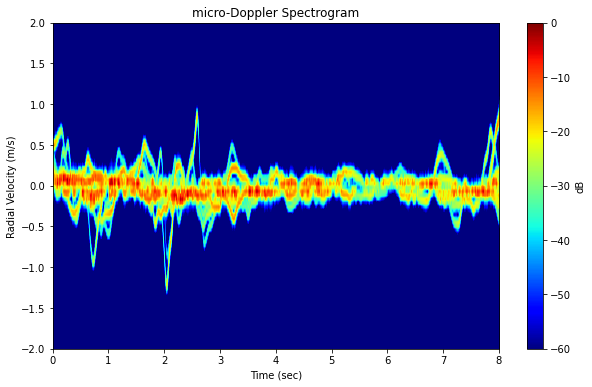

In [10]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(10, 6))
plt.imshow(20 * np.log10(np.abs(sx2 / np.max(sx2))), extent=[timeAxis[0], timeAxis[-1], freqAxis[0], freqAxis[-1]], aspect='auto', origin='lower')
plt.title('micro-Doppler Spectrogram')
plt.xlabel('Time (sec)')
plt.ylabel('Radial Velocity (m/s)')
plt.colorbar(label='dB')
plt.clim(20 * np.log10(np.abs(sx2 / np.max(sx2))).max() - 60, 20 * np.log10(np.abs(sx2 / np.max(sx2))).max())
plt.set_cmap('jet')
plt.axis([0, 8, -2, 2])
plt.show()

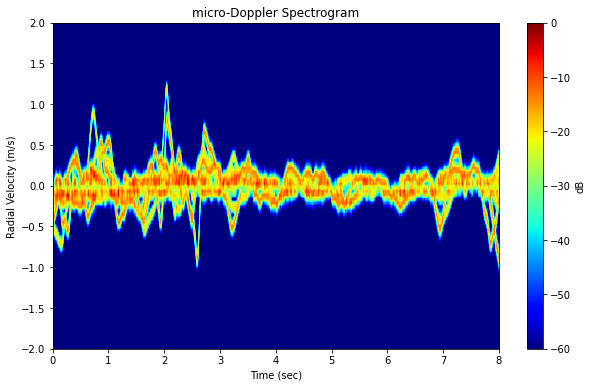

In [13]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(10, 6))
plt.imshow(20 * np.log10(np.abs(sx2 / np.max(sx2))), extent=[timeAxis[0], timeAxis[-1], freqAxis[0], freqAxis[-1]], aspect='auto', origin='lower')
plt.title('micro-Doppler Spectrogram')
plt.xlabel('Time (sec)')
plt.ylabel('Radial Velocity (m/s)')
plt.colorbar(label='dB')
plt.clim(20 * np.log10(np.abs(sx2 / np.max(sx2))).max() - 60, 20 * np.log10(np.abs(sx2 / np.max(sx2))).max())
plt.set_cmap('jet')
plt.axis([0, 8, -2, 2])
plt.show()

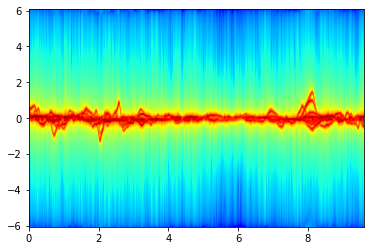

In [9]:
plt.imshow(20 * np.log10(np.abs(sx2 / np.max(sx2))), extent=[timeAxis[0], timeAxis[-1], freqAxis[0], freqAxis[-1]], aspect='auto', origin='lower')

In [5]:
import matplotlib.pyplot as plt

# Assuming 'sx2' is the spectrogram data from the previous steps

# Time and Frequency Axes
timeAxis = np.linspace(0, numCPI * frameDuration, numCPI)
freqAxis = np.linspace(-Vmax / 2, Vmax / 2, config['nfft'])

# Visualization
plt.figure(figsize=(10, 6))
plt.imshow(20 * np.log10(np.abs(sx2 / np.max(sx2))), extent=[timeAxis[0], timeAxis[-1], freqAxis[0], freqAxis[-1]], aspect='auto', origin='lower')
plt.title('micro-Doppler Spectrogram')
plt.xlabel('Time (sec)')
plt.ylabel('Radial Velocity (m/s)')
plt.colorbar(label='dB')
plt.clim(20 * np.log10(np.abs(sx2 / np.max(sx2))).max() - 40, 20 * np.log10(np.abs(sx2 / np.max(sx2))).max())
plt.set_cmap('jet')
plt.axis([0, 10, -2, 2])
plt.show()

NameError: name 'numCPI' is not defined

In [6]:
# prompt: plt figure, two subplots in  a row, one plot range profile, the other plot mti_filtered
# Time and Frequency Axes
timeAxis = np.linspace(0, numCPI * frameDuration, numCPI)
rangeAxis = np.linspace(0, Rmax, config['nfft'])

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
cax_0 = axs[0].imshow(20 * np.log10(np.abs(range_profile / np.max(range_profile))), extent=[timeAxis[0], timeAxis[-1], rangeAxis[0], rangeAxis[-1]], aspect='auto', origin='lower')
cax_0.set_clim(20 * np.log10(np.abs(range_profile / np.max(range_profile))).max() - 50, 20 * np.log10(np.abs(range_profile / np.max(range_profile))).max())
axs[0].set_title('Range Profile')
axs[0].set_xlabel('Time (sec)')
axs[0].set_ylabel('Range (m)')
cax_1 = axs[1].imshow(20 * np.log10(np.abs(mti_filtered / np.max(mti_filtered))), extent=[timeAxis[0], timeAxis[-1], rangeAxis[0], rangeAxis[-1]], aspect='auto', origin='lower')
cax_1.set_clim(20 * np.log10(np.abs(mti_filtered / np.max(mti_filtered))).max() - 50, 20 * np.log10(np.abs(mti_filtered / np.max(mti_filtered))).max())
axs[1].set_title('Range Profile after MTI')
axs[1].set_xlabel('Time (sec)')
axs[1].set_ylabel('Range (m)')
plt.set_cmap('jet')
plt.show()

NameError: name 'numCPI' is not defined